In [91]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import XXPlusYYGate
from qiskit.opflow import I, Z, X, Y
import numpy as np
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import CPhaseGate
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.providers.basicaer import QasmSimulatorPy  
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, Sampler, Options, Estimator

from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler as Aer_Sam
from qiskit.compiler import transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.providers.fake_provider import *
from qiskit.primitives import BackendSampler
from qiskit.providers.fake_provider import FakeCairoV2
from qiskit.providers.fake_provider import FakeNairobiV2

In [2]:
from qiskit.primitives import BackendEstimator
from qiskit.primitives import BackendSampler
from qiskit_aer.primitives import Estimator as Aer_Est
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Save your credentials on disk.
QiskitRuntimeService.save_account(channel='ibm_quantum' ,overwrite=True , token='039bdd576d3eebd22ebd6d4b75ea52f103bb1d675a648692312a2204405486c1481afa854b62f7ce7fa51231121e6f3066ec73feebfb5a7e983939fdadd35758')


In [4]:
service = QiskitRuntimeService()

In [5]:
from qiskit_ibm_provider import IBMProvider

# Save your credentials on disk.
IBMProvider.save_account(overwrite=True , token='039bdd576d3eebd22ebd6d4b75ea52f103bb1d675a648692312a2204405486c1481afa854b62f7ce7fa51231121e6f3066ec73feebfb5a7e983939fdadd35758')

provider = IBMProvider()

In [6]:
service.backends()

[<IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibmq_qasm_simulator')>]

In [7]:
from qiskit.providers.aer import AerSimulator
backend = service.get_backend('ibm_brisbane')
backend_sim = AerSimulator.from_backend(backend)
"""for i in range(10):
    qc = QuantumCircuit(10)
    qc.x(i)
    res = get_expectaion_value_real(Measure_basis(10),qc)
    exa = get_expectaion_value_Sim(Measure_basis(10),qc)
    print(f'exact : {exa}')
    print(res)"""


"for i in range(10):\n    qc = QuantumCircuit(10)\n    qc.x(i)\n    res = get_expectaion_value_real(Measure_basis(10),qc)\n    exa = get_expectaion_value_Sim(Measure_basis(10),qc)\n    print(f'exact : {exa}')\n    print(res)"

In [8]:
qc=QuantumCircuit(3)

In [9]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit.providers.aer import AerSimulator
backend=FakeCairoV2()


In [10]:
service.backends()

[<IBMBackend('ibm_perth')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_lagos')>,
 <IBMBackend('ibmq_qasm_simulator')>]

In [11]:
def Foward_diffrentiaion(list, h):
    if len(list) != 5:
        print("lenth is not proper")
        raise NotImplementedError
    else:
        return (1/12*list[0]-2/3*list[1]-0*list[2]+2/3*list[3]-1/12*list[4])/h


def Foward_diffrentiaion_SC(list, h):
    if len(list) != 5:
        print("lenth is not proper")
        raise NotImplementedError
    else:
        return (-1/12*list[0]+4/3*list[1]-5/2*list[2]+4/3*list[3]-1/12*list[4])/h


def fit_curve_exp(my_function, x, y):
    b = -Foward_diffrentiaion_SC(y, 1)/Foward_diffrentiaion(y, 1)
    if b > 5:
        b = 5
    elif b < -5:
        b = -5
    a = -Foward_diffrentiaion(y, 1)/b
    c = y[2]-a
    value1, cov1 = curve_fit(my_function, x, y,
                             maxfev=20000, p0=[a, b, y[2]-a])
    e = Foward_diffrentiaion_SC(y, 1)/Foward_diffrentiaion(y, 1)
    if e > 5:
        e = 5
    elif e < -5:
        e = -5
    d = -Foward_diffrentiaion(y, 1)/e
    f = y[2]-d
    value2, cov2 = curve_fit(my_function, x, y,
                             maxfev=20000, p0=[d, e, y[2]-f])
    if np.sum(cov1**2) > np.sum(cov2**2):
        value = value2
    else:
        value = value1
    return value

In [12]:
def Hamiltonian(num_sites,U,t):
    a = []
    a_ = []
    for i in range(num_sites*2):
        cre = ((X-1j*Y)/2)
        ani = ((X+1j*Y)/2)
        if i ==0:
            temp = 1
        else : 
            temp = Z
        for j in range(i-1):
            temp = temp^Z
        a.append(temp^cre^(I^(2*num_sites-i-1)))
        a_.append(temp^ani^(I^(2*num_sites-i-1)))
    ## number_op
    n=[]
    for i in range(num_sites):
        n.append(U*((a[i]@a_[i])@(a[i+num_sites]@a_[i+num_sites])))
    ## cross_op
    Cross=[]
    for i in range(num_sites-1):
        Cross.append(-t*((a_[i]@a[i+1])+(a_[i+1]@a[i])))
    for i in range(num_sites-1):
        Cross.append(-t*(a_[i+num_sites]@a[i+1+num_sites]+a_[i+num_sites+1]@a[i+num_sites]))
    Hamiltonian=0*I^num_sites*2
    for i in Cross:
        Hamiltonian+=i
    for i in n:
        Hamiltonian+=i
    return Hamiltonian.reduce()
        

In [13]:
def Hamiltonian1(Q_num,J=1,l=1,h=1):
    H = []
    for i in range(Q_num-1):
        if i == 0:
            op = -J*((Z ^ Z)+h*(l*I ^ X)+(I ^ Z))
        else:
            op = I
        for j in range(1, Q_num-1):
            if j == i:
                op = op ^ (-J*((Z ^ Z)+h*(l*I ^ X)+(I ^ Z)))
            else:
                op = op ^ I
        H.append(op)
    A = -h*X
    for i in range(Q_num-1):
        A = A ^ I
    for i in H:
        A = A+i
    B = -J*Z
    for i in range(Q_num-1):
        B = B ^ I
    A = A+B

    return(A)

In [192]:
from qiskit.opflow import StateFn, PauliExpectation, CircuitSampler
from qiskit_aer import AerSimulator
def get_expectaion_value_real(Ham,time_H,shots = 5000):
    estimator = BackendEstimator(backend_sim)
    estimator.set_transpile_options(optimization_level=0)
    time_H=transpile(time_H,optimization_level=0)
    job = estimator.run(circuits=time_H,observables=[Ham],shots=shots,optimization_level=0)
    result=job.result().values[0]
    return result
def get_Prob_real(time_H):
    sampler = BackendEstimator(backend = backend_sim)
    job = sampler.run(time_H)
    result=job.result()
    return result

In [15]:
def my_function(x, a, b, c):
    return a * np.exp(-b * x) + c

In [16]:

def get_expectaion_value_Sim(Ham,time_H):
    estimator = Aer_Est(run_options={'shots':50000})
    job = estimator.run(circuits=time_H,observables=[Ham])
    result=job.result().values
    return result
def get_Prob_Sim(time_H):
    time_H.measure_all()
    sampler = Aer_Sam()
    job = sampler.run(time_H)
    result=job.result()
    return result
def get_expectaion_value_IBMQ(Ham, qc_list):
    Hams=[]
    for i in range(len(qc_list)):
        Hams.append(Ham)
    options=Options()
    options.optimization_level = 0
    options.shots =20000
    with Session(service=service, backend=backend) as session:
        estimator=Estimator(session=session,options=options)
        job = estimator.run(circuits=qc_list,observables=Hams)
        result = job.result().values
    return result

In [17]:
def sampler_result_IBMQ(qc_list,parameters=None):
    temp_list = []
    for i in qc_list:
        if i.clbits == 0:
            i.measure_all()
            temp_list.append(i)
    options=Options()
    options.optimization_level = 0
    options.shots =20000
    with Session(service=service, backend=backend) as session:
        sampler=Sampler(session=session,options=options)
        job = sampler.run(circuits=temp_list)
        result_list = job.result().quasi_dists
    resultant_list = []
    for result in result_list:
        key_values = list(result.keys())
        values = list(result.values())
        resultant = {}
        index = 0
        for i in key_values:
            temp = format(i,'b').zfill(int(qc.num_qubits))
            resultant[temp] = values[index]
            index += 1
        resultant_list.append(resultant)
    return resultant_list
    

In [18]:
def Measure_basis(Q_num):
    H = Z ^ (I ^ (Q_num-1))
    for i in range(Q_num-1):
        A = I
        for j in range(Q_num-1):
            k = j
            if k != i:
                A = A ^ I
            else:
                A = A ^ Z

        H = H+A

    return(H)


In [19]:
def HV_ansatz(num_sites,reps=1):
    qc = QuantumCircuit(num_sites*2,name = 'HV_ansatz')
    parameter = ParameterVector('theta1',num_sites*reps)
    parameter1 =  ParameterVector('theta2',(num_sites-1)*2*reps)
    parameter2 =  ParameterVector('theta3',(num_sites-1)*2*reps)
    for j in range(reps):
        for i in range(num_sites-1):
            temp = i+(num_sites-1)*j*2
            qc.append(XXPlusYYGate(parameter1[temp],parameter2[temp]),[i,i+1])
        for i in range(num_sites-1):
            temp = i+(num_sites-1)*j*2
            qc.append(XXPlusYYGate(parameter1[temp+num_sites-1],parameter2[temp+num_sites-1]),[i+num_sites,i+1+num_sites])
        for i in range(num_sites):
            temp = i+(num_sites)*j
            qc.append(CPhaseGate(parameter[temp]),[i,i+num_sites])
    return qc

In [20]:
def sampler_result(qc,parameters=None):
    temp1 = QuantumCircuit(qc.num_qubits)
    if parameters!=None:
        for i in parameters:
            temp1 = qc.bind_parameters(parameters)
    else:
        temp1 = qc
    temp1.measure_all()
    sampler = BackendSampler(backend=backend_sim)
    job = sampler.run(temp1)
    result = job.result().quasi_dists[0]
    key_values = list(result.keys())
    values = list(result.values())
    resultant = {}
    index = 0
    for i in key_values:
        temp = format(i,'b').zfill(int(qc.num_qubits))
        resultant[temp] = values[index]
        index += 1

    return resultant
    

In [140]:
class hubard_trotter():
    def __init__(self,num_qubits, step, tau,Hamiltonian,initial_state=None,backend=None):
        self.num = num_qubits
        self.t = tau/step
        self.gate = PauliEvolutionGate(Hamiltonian,time=self.t)
        if initial_state == None:
            self.init = '0'*self.num
        else:
            self.init = initial_state
        if backend == None:
            self.backend = service.backends(simulator=True)[0]
        else : 
            self.backend = backend
        self.reps = step
    def circ(self):
        qc = QuantumCircuit(self.num)
        qc.initialize(self.init)
        for i in range(self.reps):
            qc.append(self.gate,qc.qubits)
        return qc
    def extra_polate(self,reps):
        qc = self.circ()
        temp1 = qc.qasm()
        temp = temp1.split('\n')
        temp_temp = []
        for i in temp:
            temp = i.split(' ')
            if temp[0]=='cx':
                temp_temp.append(i)
                for j in range(reps):
                    temp_temp.append(i)
                    temp_temp.append(i)
            else:
                temp_temp.append(i)
        temp_temp_conbine = '\n'.join(temp_temp)
        qc_result = QuantumCircuit(self.num)
        qc_result = qc_result.from_qasm_str(temp_temp_conbine)
        return qc_result


In [29]:
def extra_polate_circ(circ,reps):
        qc = circ
        temp1 = qc.qasm()
        temp = temp1.split('\n')
        temp_temp = []
        for i in temp:
            temp = i.split(' ')
            if temp[0]=='cx':
                temp_temp.append(i)
                for j in range(reps):
                    temp_temp.append(i)
                    temp_temp.append(i)
            else:
                temp_temp.append(i)
        temp_temp_conbine = '\n'.join(temp_temp)
        qc_result = QuantumCircuit(qc.num_qubits)
        qc_result = qc_result.from_qasm_str(temp_temp_conbine)
        return qc_result

In [22]:
class IBM_analy():
    def __init__(self,values,round = 3, name = None, polate_num = None):
        if len(values)==0:
            self.std = []
            self.mean = []
        else:
            self.std = [np.round(np.std(values),round)]
            self.mean = [np.round(np.mean(values),round)]
        self.round = round
        self.name = name
        if polate_num != None:
            self.p_num = [polate_num]
        else:
            self.p_num = []
    def append(self,values,polate_num = None):
        round = self.round
        self.std.append(np.round(np.std(values),round))
        self.mean.append(np.round(np.mean(values),round))
        if polate_num != None:
            self.p_num.append(polate_num)
        

In [23]:
IBM_list = []
for i in service.backends(simulator = False):
    IBM_list.append(IBM_analy([],name=i.name))

In [24]:
initial_state = '1111'
num_qubits = 4
qc = QuantumCircuit(num_qubits)
qc.initialize(initial_state)
qc = qc.decompose(reps=1)
REM_list = []
exact_data = []
list_ = []
Raw_data = []
Meas = Measure_basis(num_qubits)
Ham = Hamiltonian1(num_qubits,h=0.3)

In [25]:
k = 3
polate_num = 3
B = hubard_trotter(num_qubits,2,1*k,Hamiltonian=Ham,initial_state=initial_state).extra_polate(polate_num)
exact_data = get_expectaion_value_Sim(Meas,B)
print("Exact data : ", exact_data)
index = 0
for i in service.backends(simulator = False):
    result_list = []
    backend = i
    if backend.num_qubits<num_qubits:
        index +=1
        continue
    try:
        backend_sim = AerSimulator.from_backend(backend)
    except:
        index +=1
        continue
    for j in range(20):
        result_list.append(get_expectaion_value_real(Meas,B))
    result_list = np.round(result_list,3)
    IBM_list[index].append(result_list,polate_num)
    print(f"결과 : {result_list}")
    std = np.std(result_list)
    print(f"백엔드 : {i} , 표준편차 : {std}")
    print(f"최대 - 최소 : {np.max(result_list)-np.min(result_list)}")
    print("\n")
    index +=1

Exact data :  [-1.53528]
결과 : [-0.066 -0.082  0.101 -0.035  0.108  0.246 -0.053 -0.199  0.033  0.089
 -0.168  0.107  0.13   0.144  0.254 -0.036 -0.106  0.272  0.072  0.218]
백엔드 : <IBMBackend('ibm_perth')> , 표준편차 : 0.13678686888733144
최대 - 최소 : 0.47100000000000003


결과 : [-0.369 -0.377 -0.384 -0.363 -0.381 -0.382 -0.37  -0.373 -0.372 -0.378
 -0.375 -0.373 -0.36  -0.383 -0.372 -0.379 -0.349 -0.37  -0.377 -0.37 ]
백엔드 : <IBMBackend('ibm_brisbane')> , 표준편차 : 0.008223594104769527
최대 - 최소 : 0.03500000000000003


결과 : [-0.277 -0.241 -0.2   -0.257 -0.142 -0.235 -0.226 -0.279 -0.274 -0.298
 -0.344 -0.224 -0.315 -0.238 -0.124 -0.252 -0.271 -0.174 -0.237 -0.281]
백엔드 : <IBMBackend('ibm_nairobi')> , 표준편차 : 0.05293248057667428
최대 - 최소 : 0.21999999999999997


결과 : [-0.149 -0.185 -0.016 -0.241 -0.119 -0.176 -0.237 -0.252 -0.121 -0.145
 -0.074 -0.161 -0.15  -0.146 -0.165 -0.229 -0.181 -0.16  -0.081 -0.13 ]
백엔드 : <IBMBackend('ibm_lagos')> , 표준편차 : 0.05737760887314841
최대 - 최소 : 0.236




In [26]:
min = 1000
max = 0
index = 0
min_dex = 0
max_dex = 0
for i in IBM_list:
    try:
        if min>i.std[0]:
            min = i.std
            min_dex = index
        if max<i.std[0]:
            max = i.std
            max_dex = index
        index+=1
    except:
        index +=1 

In [169]:
backend = service.backend(IBM_list[min_dex].name)
backend_sim = AerSimulator.from_backend(backend)

In [28]:
backend = service.backend(IBM_list[max_dex].name)
backend_sim = AerSimulator.from_backend(backend)

In [111]:
def REM_exp_ham(initial_state,step,ref_value = -0.23):
    if ref_value == -0.23:
        ref_value = 0
        for i in initial_state:
            if i =='1':
                ref_value -=1
            else:
                ref_value +=1
    Meas = Measure_basis(len(initial_state))
    REM_circ = hubard_trotter(len(initial_state),step,0,Hamiltonian=Ham,initial_state=initial_state).circ()
    REM_circ = REM_circ.decompose(reps=3)
    REM_circ = transpile(REM_circ,optimization_level=0)
    value = get_expectaion_value_real(Ham,REM_circ)
    return ref_value - value

In [113]:
def REM_exp_meas(initial_state,step,ref_value = -0.23):
    if ref_value == -0.23:
        ref_value = 0
        for i in initial_state:
            if i =='1':
                ref_value -=1
            else:
                ref_value +=1
    Meas = Measure_basis(len(initial_state))
    REM_circ = hubard_trotter(len(initial_state),step,0,Hamiltonian=Ham,initial_state=initial_state).circ()
    REM_circ = REM_circ.decompose(reps=3)
    REM_circ = transpile(REM_circ,optimization_level=0)
    value = get_expectaion_value_real(Meas,REM_circ)
    return ref_value - value

In [185]:
def REM_exp_append(initial_state,circ,ref_value = -0.23):
    temp_circ = circ.copy()
    if ref_value == -0.23:
        ref_value = 0
        for i in initial_state:
            if i =='1':
                ref_value -=1
            else:
                ref_value +=1
    Meas = Measure_basis(len(initial_state))
    temp_circ.append(PauliEvolutionGate(Ham,time=0),circ.qubits)
    value = get_expectaion_value_real(Meas,temp_circ)
    return ref_value - value

In [ ]:
def get_statevector(qc, paras):
    index = 0
    for i in qc.parameters:
        qc = qc.bind_parameters({i:paras[index]})
        index+=1
    qc.save_statevector()
    job = execute(qc, simulator)
    job_result = job.result()
    res = job_result
    return res

In [181]:
backend = FakeKolkata()
backend_sim = AerSimulator.from_backend(backend)

## for step REM

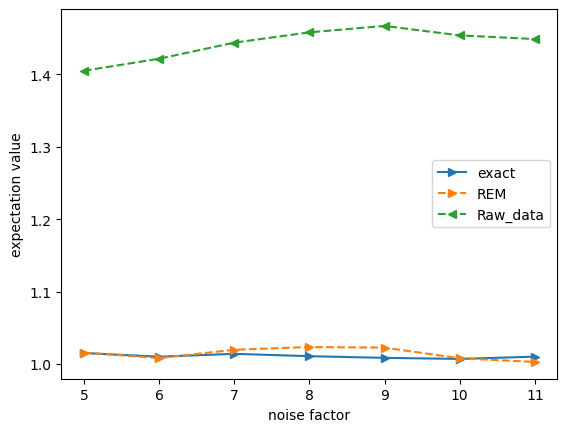

In [170]:
initial_state = '111111'
num_qubits = 6
steps = 5
qc = QuantumCircuit(num_qubits)
qc.initialize(initial_state)
qc = qc.decompose(reps=1)
REM_list = []
exact_data = []
list_ = []
Raw_data = []
Meas = Measure_basis(num_qubits)
Ham = Hamiltonian1(num_qubits,h=0.3)

step_list = [int(i) for i in range(5,12)]
circ_list = []
for i in step_list:
    circ_list.append(hubard_trotter(num_qubits,i,0.3,Hamiltonian=Ham,initial_state=initial_state).circ())


for i in range(len(step_list)):
    exact_data.append(get_expectaion_value_Sim(Ham,circ_list[i]))

for i in range(len(step_list)):
    Raw_data.append(get_expectaion_value_real(Ham,circ_list[i]))

for i in range(len(step_list)):
    REM = REM_exp_ham(initial_state,step_list[i],exact_data[0])
    REM_list.append(Raw_data[i]+REM)
        
plt.plot(step_list,exact_data,"->",label="exact")
plt.plot(step_list,REM_list,"-->",label="REM")
plt.plot(step_list,Raw_data,"<--",label="Raw_data")
plt.xlabel("noise factor")
plt.ylabel("expectation value")
plt.legend()



## for time REM

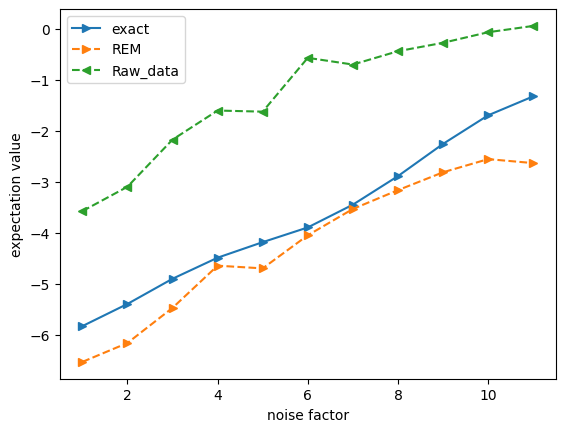

In [193]:
initial_state = '111111'
num_qubits = 6
steps = 5
qc = QuantumCircuit(num_qubits)
qc.initialize(initial_state)
qc = qc.decompose(reps=1)
REM_list = []
exact_data = []
list_ = []
Raw_data = []
Meas = Measure_basis(num_qubits)
Ham = Hamiltonian1(num_qubits,h=0.3)

time_list = [int(i) for i in range(1,12)]
circ_list = []
circ_list_REM = []
for i in time_list:
    circ_list.append(hubard_trotter(num_qubits,steps+i,0.4*i,Hamiltonian=Ham,initial_state=initial_state).circ())
for i in time_list:
    circ_list_REM.append(hubard_trotter(num_qubits,steps-1+i,0.4*i,Hamiltonian=Ham,initial_state=initial_state).circ())

for i in range(len(time_list)):
    exact_data.append(get_expectaion_value_Sim(Meas,circ_list[i]))

for i in range(len(time_list)):
    Raw_data.append(get_expectaion_value_real(Meas,circ_list[i]))

for i in range(len(time_list)):
    if i == 0:
        REM = REM_exp_meas(initial_state,steps)
        REM_list.append(Raw_data[i]+REM)
        ref = Raw_data[i]+REM
    else:
        REM = REM_exp_append(initial_state,circ_list_REM[i-1],ref)
        REM_list.append(Raw_data[i]+REM)
        ref = Raw_data[i]+REM
        
plt.plot(time_list,exact_data,"->",label="exact")
plt.plot(time_list,REM_list,"-->",label="REM")
plt.plot(time_list,Raw_data,"<--",label="Raw_data")
plt.xlabel("noise factor")
plt.ylabel("expectation value")
plt.legend()

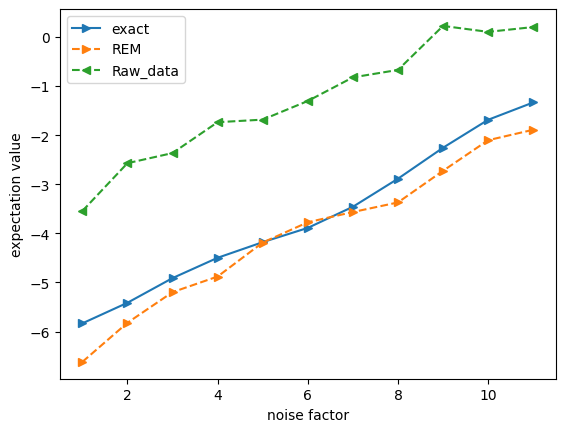

In [188]:
initial_state = '111111'
num_qubits = 6
steps = 5
qc = QuantumCircuit(num_qubits)
qc.initialize(initial_state)
qc = qc.decompose(reps=1)
REM_list = []
exact_data = []
list_ = []
Raw_data = []
Meas = Measure_basis(num_qubits)
Ham = Hamiltonian1(num_qubits,h=0.3)

time_list = [int(i) for i in range(1,12)]
circ_list = []
circ_list_REM = []
for i in time_list:
    circ_list.append(hubard_trotter(num_qubits,steps+i,0.4*i,Hamiltonian=Ham,initial_state=initial_state).circ())
for i in time_list:
    circ_list_REM.append(hubard_trotter(num_qubits,steps-1+i,0.4*i,Hamiltonian=Ham,initial_state=initial_state).circ())

for i in range(len(time_list)):
    exact_data.append(get_expectaion_value_Sim(Meas,circ_list[i]))

for i in range(len(time_list)):
    Raw_data.append(get_expectaion_value_real(Meas,circ_list[i]))

for i in range(len(time_list)):
    if i == 0:
        REM = REM_exp_meas(initial_state,steps)
        REM_list.append(Raw_data[i]+REM)
        ref = Raw_data[i]+REM
    else:
        REM = REM_exp_append(initial_state,circ_list_REM[i-1],ref)
        REM_list.append(Raw_data[i]+REM)
        ref = Raw_data[i]+REM
        
plt.plot(time_list,exact_data,"->",label="exact")
plt.plot(time_list,REM_list,"-->",label="REM")
plt.plot(time_list,Raw_data,"<--",label="Raw_data")
plt.xlabel("noise factor")
plt.ylabel("expectation value")
plt.legend()

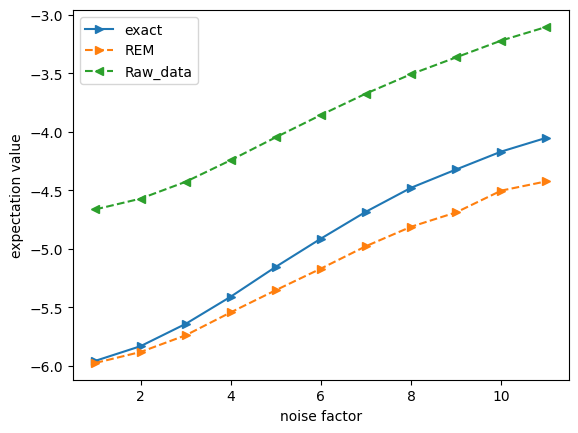

In [176]:
initial_state = '111111'
num_qubits = 6
steps = 5
qc = QuantumCircuit(num_qubits)
qc.initialize(initial_state)
qc = qc.decompose(reps=1)
REM_list = []
exact_data = []
list_ = []
Raw_data = []
Meas = Measure_basis(num_qubits)
Ham = Hamiltonian1(num_qubits,h=0.3)

time_list = [int(i) for i in range(1,12)]
circ_list = []
circ_list_REM = []
for i in time_list:
    circ_list.append(hubard_trotter(num_qubits,steps,0.2*i,Hamiltonian=Ham,initial_state=initial_state).circ())
for i in time_list:
    circ_list_REM.append(hubard_trotter(num_qubits,steps-1,0.2*i,Hamiltonian=Ham,initial_state=initial_state).circ())

for i in range(len(time_list)):
    exact_data.append(get_expectaion_value_Sim(Meas,circ_list[i]))

for i in range(len(time_list)):
    Raw_data.append(get_expectaion_value_real(Meas,circ_list[i]))

for i in range(len(time_list)):
    if i == 0:
        REM = REM_exp_meas(initial_state,steps)
        REM_list.append(Raw_data[i]+REM)
        ref = Raw_data[i]+REM
    else:
        REM = REM_exp_meas(initial_state,steps)
        REM_list.append(Raw_data[i]+REM)
        ref = Raw_data[i]+REM
        
plt.plot(time_list,exact_data,"->",label="exact")
plt.plot(time_list,REM_list,"-->",label="REM")
plt.plot(time_list,Raw_data,"<--",label="Raw_data")
plt.xlabel("noise factor")
plt.ylabel("expectation value")
plt.legend()